In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
from scipy import stats

In [2]:
def analyze_question_accuracy_from_merged(merged_csv_path, ground_truth_json_path):
    '''accuracy analysis for each question from merged qna_results.csv'''
    
    # Read data
    df = pd.read_csv(merged_csv_path)
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    overall_results = []
    for q in questions:
        correct = 0
        total = 0
        accuracies = []
        
        for _, row in df.iterrows():
            case_id = row["case_id"]
            if case_id in gt_data:
                pred = str(row[q]).strip()
                true = str(gt_data[case_id][q]).strip()
                
                if pred == true and pred != "":
                    correct += 1
                    accuracies.append(1)
                else:
                    accuracies.append(0)
                total += 1
        
        accuracy = round(correct / total * 100, 2) if total > 0 else 0
        std_accuracy = round(pd.Series(accuracies).std() * 100, 2) if len(accuracies) > 0 else 0
        overall_results.append({"question": q, "accuracy": accuracy, "std": std_accuracy, "correct": correct, "total": total})
        print(f"{q}: {accuracy}% ± {std_accuracy}% ({correct}/{total})")
    
    rag_dir = os.path.dirname(os.path.dirname(merged_csv_path))
    output_dir = os.path.join(rag_dir, "eval")
    os.makedirs(output_dir, exist_ok=True)

    base_name = os.path.basename(merged_csv_path).replace("_results_merged.csv", "")
    output_filename = f"{base_name}_question_accuracy.csv"
    overall_df = pd.DataFrame(overall_results)
    overall_df.to_csv(os.path.join(output_dir, output_filename), index=False)
    print(f"\n result saved: {output_dir}")
    return overall_df

In [3]:
BASE_DIR = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance"
ground_truth_path = os.path.join(BASE_DIR, "dataset/ground_truth.json")

baseline_path = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_baseline_matched_results_merged.csv"

baseline_matched_df = analyze_question_accuracy_from_merged(
    merged_csv_path=baseline_path,
    ground_truth_json_path=ground_truth_path
)

Q0: 100.0% ± 0.0% (615/615)
Q1: 61.3% ± 48.75% (377/615)
Q2: 62.44% ± 48.47% (384/615)
Q3: 71.54% ± 45.16% (440/615)
Q4: 33.17% ± 47.12% (204/615)
Q5: 73.66% ± 44.08% (453/615)
Q6: 71.71% ± 45.08% (441/615)
Q7: 16.91% ± 37.52% (104/615)
Q8: 63.09% ± 48.3% (388/615)

 result saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/eval


In [2]:
df = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/name_retrieval/evaluation_results/name_result_fin.csv')
for col in df.columns:
    if 'Precision' in col or 'Recall' in col or 'F1-Score' in col:
        df[col] = pd.to_numeric(df[col].astype(str).str.rstrip('%'), errors='coerce')

df.head()

,model,prompt,iteration,ret,total,Manual Match,LLM Match,Manual Match Precision (%),Manual Match Recall (%),Manual Match F1-Score,LLM Match Precision (%),LLM Match Recall (%),LLM Match F1-Score,Exact Match Precision (%),Exact Match Recall (%),Exact Match F1-Score,Regex Match Precision (%),Regex Match Recall (%),Regex Match F1-Score
0,perplexity,baseline,1,4,239,2,2,50.0,0.84,1.65,50.0,0.84,1.65,50.0,0.84,1.65,50.0,0.94,1.85
1,perplexity,explicit,1,8,239,8,8,100.0,3.35,6.48,100.0,3.35,6.48,100.0,3.35,6.48,100.0,3.76,7.25
2,perplexity,baseline,2,15,239,6,6,40.0,2.51,4.72,40.0,2.51,4.72,40.0,2.51,4.72,40.0,2.82,5.27
3,perplexity,explicit,2,8,239,8,8,100.0,3.35,6.48,100.0,3.35,6.48,100.0,3.35,6.48,100.0,3.76,7.25
4,perplexity,baseline,3,4,239,2,1,50.0,0.84,1.65,25.0,0.42,0.82,50.0,0.84,1.65,50.0,0.94,1.85


In [6]:
df['model_prompt'] = df['model'] + ' + ' + df['prompt']

model_prompts = df['model_prompt'].unique()
print("Model-Prompt combinations:", model_prompts)

def calc_stats(group, metric_prefix):
    precision = group[f'{metric_prefix} Precision (%)'].values
    recall = group[f'{metric_prefix} Recall (%)'].values
    f1 = group[f'{metric_prefix} F1-Score'].values
    
    precision = precision.astype(float)
    recall = recall.astype(float)
    f1 = f1.astype(float)

    return {
        'precision_mean': np.mean(precision),
        'precision_se': stats.sem(precision),
        'recall_mean': np.mean(recall),
        'recall_se': stats.sem(recall),
        'f1_mean': np.mean(f1),
        'f1_se': stats.sem(f1)
    }

results = {
    'Exact Match': [],
    'Regex Match': [],
    'LLM Match': [],
    'Manual Match': []
}

for model_prompt in model_prompts:
    group = df[df['model_prompt'] == model_prompt]
    
    for match_type in ['Exact Match', 'Regex Match', 'LLM Match', 'Manual Match']:
        stats_dict = calc_stats(group, match_type)
        results[match_type].append(stats_dict)

precision_exact = [r['precision_mean'] for r in results['Exact Match']]
precision_regex = [r['precision_mean'] for r in results['Regex Match']]
precision_llm = [r['precision_mean'] for r in results['LLM Match']]
precision_manual = [r['precision_mean'] for r in results['Manual Match']]

recall_exact = [r['recall_mean'] for r in results['Exact Match']]
recall_regex = [r['recall_mean'] for r in results['Regex Match']]
recall_llm = [r['recall_mean'] for r in results['LLM Match']]
recall_manual = [r['recall_mean'] for r in results['Manual Match']]

f1_exact = [r['f1_mean'] for r in results['Exact Match']]
f1_regex = [r['f1_mean'] for r in results['Regex Match']]
f1_llm = [r['f1_mean'] for r in results['LLM Match']]
f1_manual = [r['f1_mean'] for r in results['Manual Match']]

precision_exact_se = [r['precision_se'] for r in results['Exact Match']]
precision_regex_se = [r['precision_se'] for r in results['Regex Match']]
precision_llm_se = [r['precision_se'] for r in results['LLM Match']]
precision_manual_se = [r['precision_se'] for r in results['Manual Match']]

recall_exact_se = [r['recall_se'] for r in results['Exact Match']]
recall_regex_se = [r['recall_se'] for r in results['Regex Match']]
recall_llm_se = [r['recall_se'] for r in results['LLM Match']]
recall_manual_se = [r['recall_se'] for r in results['Manual Match']]

f1_exact_se = [r['f1_se'] for r in results['Exact Match']]
f1_regex_se = [r['f1_se'] for r in results['Regex Match']]
f1_llm_se = [r['f1_se'] for r in results['LLM Match']]
f1_manual_se = [r['f1_se'] for r in results['Manual Match']]


Model-Prompt combinations: ['perplexity + baseline' 'perplexity + explicit' 'gpt4o-jun + baseline'
 'gpt4o-jun + explicit' 'gpt4o-oct + baseline' 'gpt4o-oct + explicit'
 'gpt5mini + baseline' 'gpt5mini + explicit']


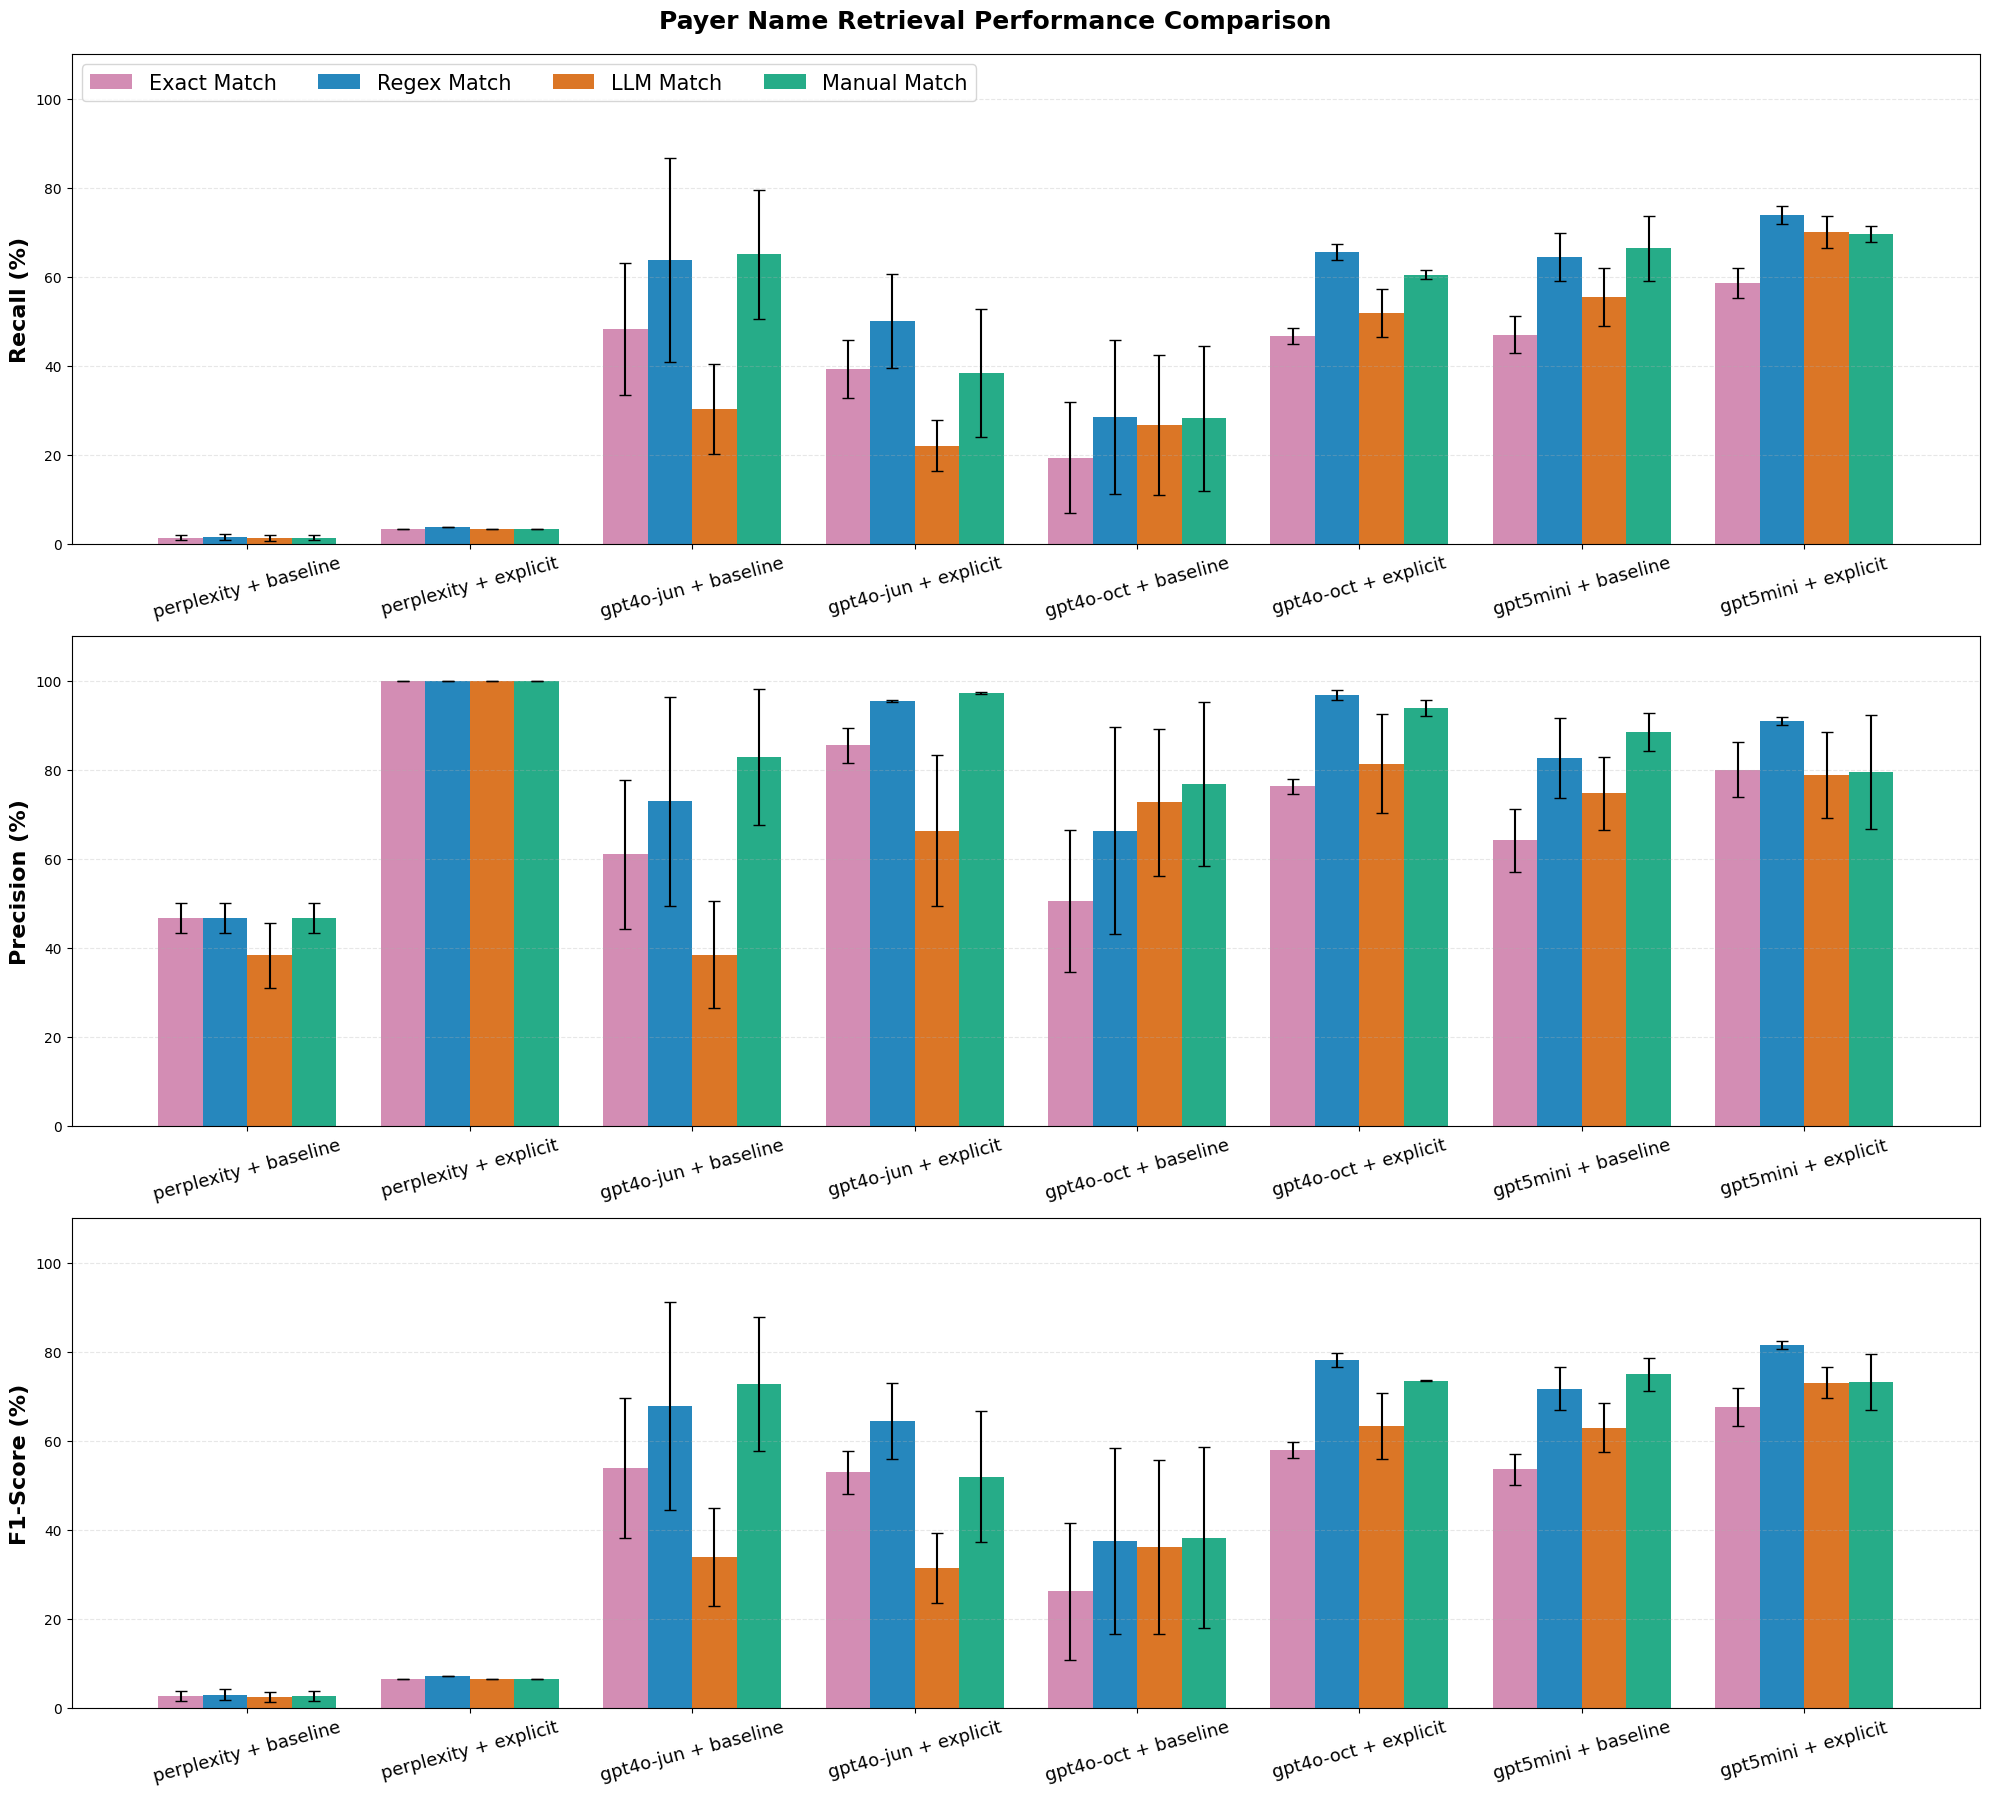

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 18))
x = np.arange(len(model_prompts))
width = 0.2  # 4개 bar를 위한 너비

# Color blind friendly colors (4개)
colors = ['#CC79A7', '#0072B2', '#D55E00', '#009E73']
labels = ['Exact Match', 'Regex Match', 'LLM Match', 'Manual Match']

# Recall 그래프 (위)
recall_data = [recall_exact, recall_regex, recall_llm, recall_manual]
recall_se_data = [recall_exact_se, recall_regex_se, recall_llm_se, recall_manual_se]

for idx, (data, se_data, label, color) in enumerate(zip(recall_data, recall_se_data, labels, colors)):
    offset = (idx - 1.5) * width
    bars = ax1.bar(x + offset, data, width, label=label, color=color, alpha=0.85,
                   yerr=se_data, error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 1.5})

ax1.set_ylabel('Recall (%)', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_prompts, fontsize=13, rotation=15, ha='center')
ax1.legend(fontsize=15, loc='upper left', ncol=4)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 110)

# Precision 그래프 (중간)
precision_data = [precision_exact, precision_regex, precision_llm, precision_manual]
precision_se_data = [precision_exact_se, precision_regex_se, precision_llm_se, precision_manual_se]

for idx, (data, se_data, label, color) in enumerate(zip(precision_data, precision_se_data, labels, colors)):
    offset = (idx - 1.5) * width
    bars = ax2.bar(x + offset, data, width, color=color, alpha=0.85,
                   yerr=se_data, error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 1.5})

ax2.set_ylabel('Precision (%)', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_prompts, fontsize=13, rotation=15, ha='center')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 110)

# F1-Score 그래프 (아래)
f1_data = [f1_exact, f1_regex, f1_llm, f1_manual]
f1_se_data = [f1_exact_se, f1_regex_se, f1_llm_se, f1_manual_se]

for idx, (data, se_data, label, color) in enumerate(zip(f1_data, f1_se_data, labels, colors)):
    offset = (idx - 1.5) * width
    bars = ax3.bar(x + offset, data, width, color=color, alpha=0.85,
                   yerr=se_data, error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 1.5})

ax3.set_ylabel('F1-Score (%)', fontsize=16, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(model_prompts, fontsize=13, rotation=15, ha='center')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_ylim(0, 110)

plt.suptitle('Payer Name Retrieval Performance Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/performance_comparison.png', dpi=300, bbox_inches='tight')
#print("Figure saved to /mnt/user-data/outputs/performance_comparison.png")

In [3]:
df['model_prompt'] = df['model'] + ' + ' + df['prompt']

model_prompts = df['model_prompt'].unique()
print("Model-Prompt combinations:", model_prompts)

def calc_stats(group, metric_prefix):
    precision = group[f'{metric_prefix} Precision (%)'].values
    recall = group[f'{metric_prefix} Recall (%)'].values
    f1 = group[f'{metric_prefix} F1-Score'].values
    
    precision = precision.astype(float)
    recall = recall.astype(float)
    f1 = f1.astype(float)

    return {
        'precision_mean': np.mean(precision),
        'precision_se': stats.sem(precision),
        'recall_mean': np.mean(recall),
        'recall_se': stats.sem(recall),
        'f1_mean': np.mean(f1),
        'f1_se': stats.sem(f1)
    }

results = {
    'Exact Match': [],
    'Regex Match': [],
    'LLM Match': [],
    'Manual Match': []
}

for model_prompt in model_prompts:
    group = df[df['model_prompt'] == model_prompt]
    
    for match_type in ['LLM Match', 'Manual Match']:
        stats_dict = calc_stats(group, match_type)
        results[match_type].append(stats_dict)

precision_llm = [r['precision_mean'] for r in results['LLM Match']]
precision_manual = [r['precision_mean'] for r in results['Manual Match']]

recall_llm = [r['recall_mean'] for r in results['LLM Match']]
recall_manual = [r['recall_mean'] for r in results['Manual Match']]

f1_llm = [r['f1_mean'] for r in results['LLM Match']]
f1_manual = [r['f1_mean'] for r in results['Manual Match']]


precision_llm_se = [r['precision_se'] for r in results['LLM Match']]
precision_manual_se = [r['precision_se'] for r in results['Manual Match']]


recall_llm_se = [r['recall_se'] for r in results['LLM Match']]
recall_manual_se = [r['recall_se'] for r in results['Manual Match']]

f1_llm_se = [r['f1_se'] for r in results['LLM Match']]
f1_manual_se = [r['f1_se'] for r in results['Manual Match']]


Model-Prompt combinations: ['perplexity + baseline' 'perplexity + explicit' 'gpt4o-jun + baseline'
 'gpt4o-jun + explicit' 'gpt4o-oct + baseline' 'gpt4o-oct + explicit'
 'gpt5mini + baseline' 'gpt5mini + explicit']


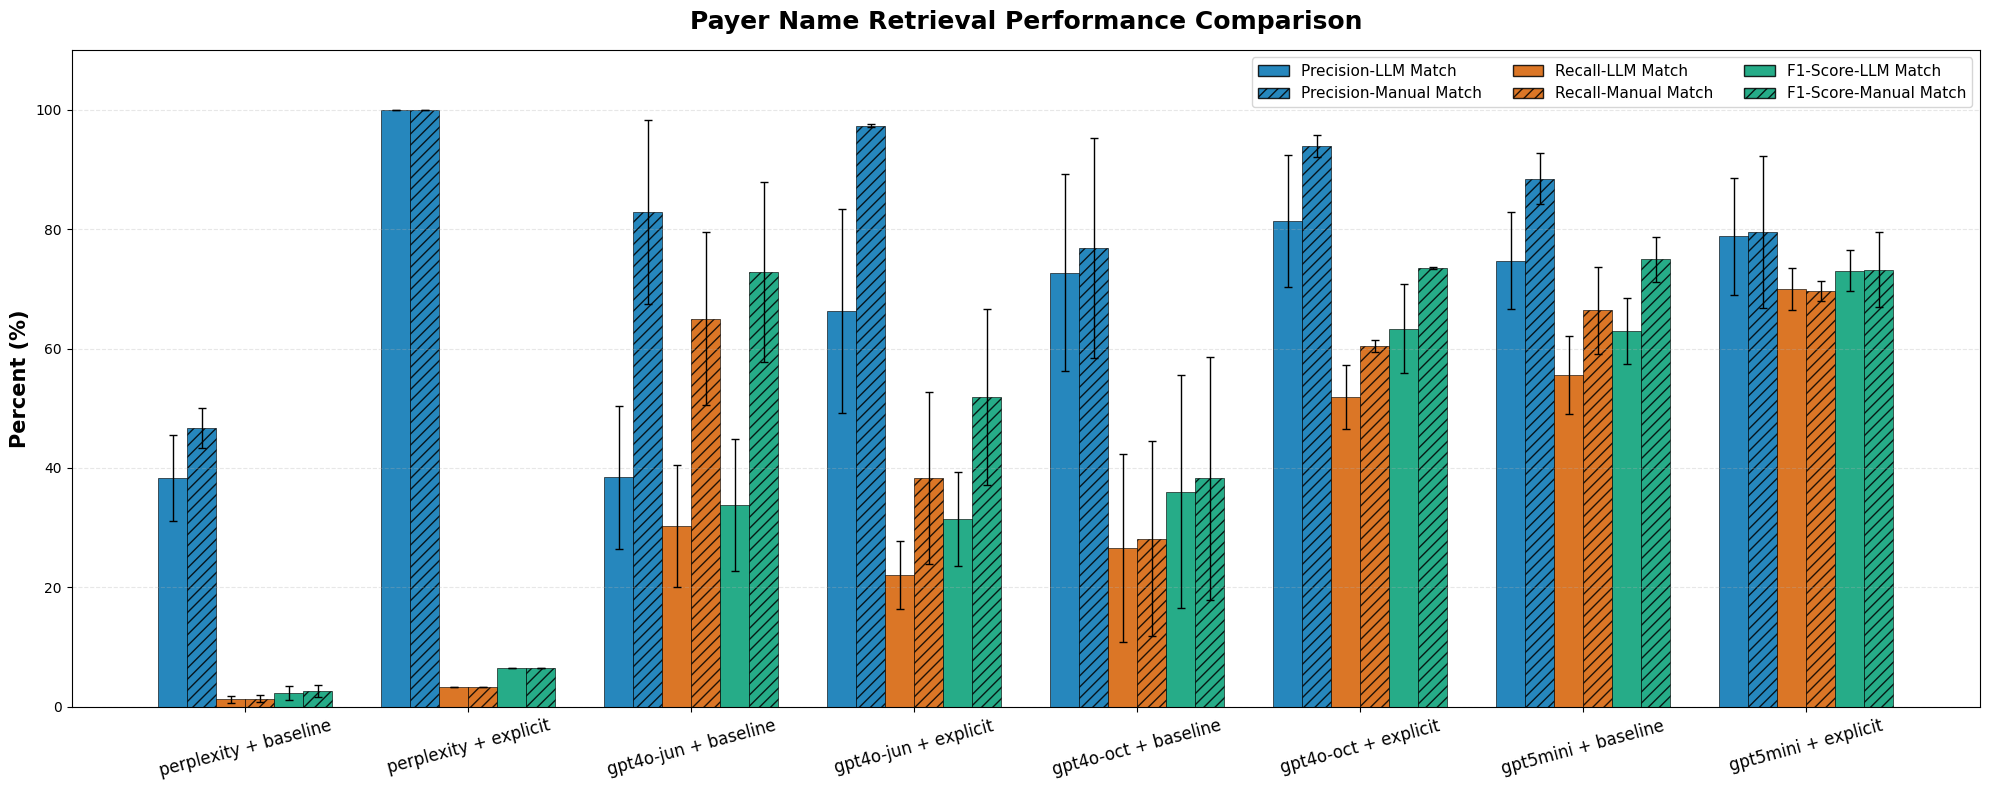

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

base_colors = ['#0072B2', '#D55E00', '#009E73']  # Precision, Recall, F1
colors = [base_colors[0], base_colors[0], base_colors[1], base_colors[1], base_colors[2], base_colors[2]]
hatches = ['', '///', '', '///', '', '///']
labels = ['Precision-LLM Match', 'Precision-Manual Match', 'Recall-LLM Match', 'Recall-Manual Match', 'F1-Score-LLM Match', 'F1-Score-Manual Match']

x = np.arange(len(model_prompts))
width = 0.13

data_list = [
    (precision_llm, precision_llm_se),
    (precision_manual, precision_manual_se),
    (recall_llm, recall_llm_se),
    (recall_manual, recall_manual_se),
    (f1_llm, f1_llm_se),
    (f1_manual, f1_manual_se)
]

for i, ((means, ses), label, color, hatch) in enumerate(zip(data_list, labels, colors, hatches)):
    offset = (i - 2.5) * width
    bars = ax.bar(x + offset, means, width, color=color, 
                 alpha=0.85, hatch=hatch, edgecolor='black', linewidth=0.5,
                 yerr=ses, error_kw={'ecolor': 'black', 'capsize': 3, 'elinewidth': 1})

# 축 설정
ax.set_ylabel('Percent (%)', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_prompts, fontsize=12, rotation=15, ha='center')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 110)

# Legend (수동 생성)
from matplotlib.patches import Rectangle

legend_elements = []
for label, color, hatch in zip(labels, colors, hatches):
    legend_elements.append(Rectangle((0, 0), 1, 1, fc=color, ec='black', 
                                     hatch=hatch, alpha=0.85, label=label))

ax.legend(handles=legend_elements, fontsize=11, loc='upper right', ncol=3)
plt.title('Payer Name Retrieval Performance Comparison', fontsize=18, fontweight='bold', pad=15)
plt.savefig('Figure1.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()

In [6]:
policy_df = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/payer_retrieval/final/policy_experiment_result_final.csv')
for col in ['Precision', 'Recall', 'F1-Score', 'Adjusted_Precision', 'Adjusted_Recall', 'Adjusted F1-Score']:
    if col in policy_df.columns:
        policy_df[col] = pd.to_numeric(policy_df[col].astype(str).str.rstrip('%'), errors='coerce')

policy_df['model_prompt'] = policy_df['Model'] + ' + ' + policy_df['Prompt']

payers = ['Aetna', 'BCBS_FEP', 'Cigna', 'UHC']

def calc_payer_stats(payer_df):
    model_prompts = payer_df['model_prompt'].unique()
    results = []
    
    for mp in model_prompts:
        group = payer_df[payer_df['model_prompt'] == mp]
        
        precision = group['Precision'].values.astype(float)
        adj_precision = group['Adjusted_Precision'].values.astype(float)
        recall = group['Recall'].values.astype(float)
        adj_recall = group['Adjusted_Recall'].values.astype(float)
        f1 = group['F1-Score'].values.astype(float)
        adj_f1 = group['Adjusted F1-Score'].values.astype(float)
        
        results.append({
            'model_prompt': mp,
            'precision_mean': np.mean(precision),
            'precision_se': stats.sem(precision),
            'adj_precision_mean': np.mean(adj_precision),
            'adj_precision_se': stats.sem(adj_precision),
            'recall_mean': np.mean(recall),
            'recall_se': stats.sem(recall),
            'adj_recall_mean': np.mean(adj_recall),
            'adj_recall_se': stats.sem(adj_recall),
            'f1_mean': np.mean(f1),
            'f1_se': stats.sem(f1),
            'adj_f1_mean': np.mean(adj_f1),
            'adj_f1_se': stats.sem(adj_f1)
        })
    
    return results

Payer: Aetna, Data List: [([np.float64(42.589999999999996), np.float64(80.0), np.float64(58.89000000000001), np.float64(42.46333333333333), np.float64(39.166666666666664), np.float64(35.35)], [np.float64(4.900309514034123), np.float64(20.000000000000004), np.float64(4.8441132659479935), np.float64(0.39666666666666595), np.float64(0.8333333333333334), np.float64(1.0100000000000005)]), ([np.float64(88.88999999999999), np.float64(80.0), np.float64(100.0), np.float64(72.62), np.float64(89.16666666666667), np.float64(90.23666666666666)], [np.float64(6.414361490696742), np.float64(20.000000000000004), np.float64(0.0), np.float64(1.189999999999998), np.float64(0.8333333333333335), np.float64(0.673333333333332)]), ([np.float64(55.55666666666667), np.float64(38.88666666666666), np.float64(44.44333333333333), np.float64(94.44333333333333), np.float64(61.11333333333334), np.float64(61.11333333333334)], [np.float64(5.556666666666667), np.float64(5.556666666666667), np.float64(5.556666666666667), n

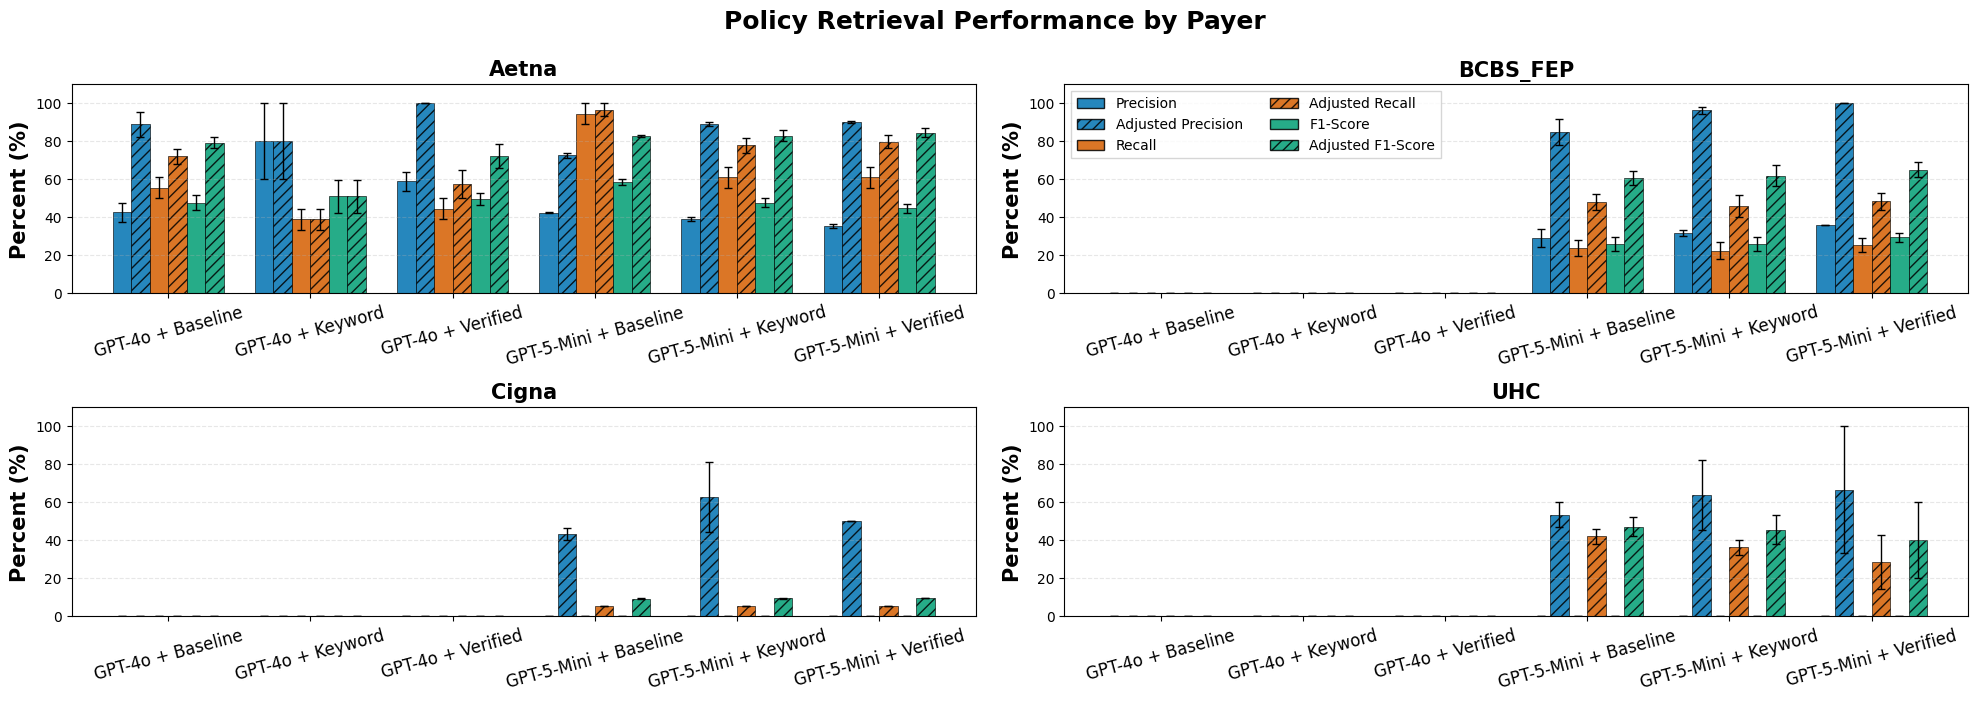

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 7))
axes = axes.flatten()

base_colors = ['#0072B2', '#D55E00', '#009E73'] 
colors = [base_colors[0], base_colors[0], base_colors[1], base_colors[1], base_colors[2], base_colors[2]]
labels = ['Precision', 'Adjusted Precision', 'Recall', 'Adjusted Recall', 'F1-Score', 'Adjusted F1-Score']
hatches = ['', '///', '', '///', '', '///']

for idx, payer in enumerate(payers):
    ax = axes[idx]
    
    payer_df = policy_df[policy_df['Payer'] == payer]
    
    payer_stats = calc_payer_stats(payer_df)
    
    precision_means = [s['precision_mean'] for s in payer_stats]
    precision_ses = [s['precision_se'] for s in payer_stats]
    adj_precision_means = [s['adj_precision_mean'] for s in payer_stats]
    adj_precision_ses = [s['adj_precision_se'] for s in payer_stats]
    recall_means = [s['recall_mean'] for s in payer_stats]
    recall_ses = [s['recall_se'] for s in payer_stats]
    adj_recall_means = [s['adj_recall_mean'] for s in payer_stats]
    adj_recall_ses = [s['adj_recall_se'] for s in payer_stats]
    f1_means = [s['f1_mean'] for s in payer_stats]
    f1_ses = [s['f1_se'] for s in payer_stats]
    adj_f1_means = [s['adj_f1_mean'] for s in payer_stats]
    adj_f1_ses = [s['adj_f1_se'] for s in payer_stats]
    
    x = np.arange(len(payer_stats))
    width = 0.13  
    
    data_list = [
        (precision_means, precision_ses),
        (adj_precision_means, adj_precision_ses),
        (recall_means, recall_ses),
        (adj_recall_means, adj_recall_ses),
        (f1_means, f1_ses),
        (adj_f1_means, adj_f1_ses)
    ]
    
    print(f"Payer: {payer}, Data List: {data_list}")

    for i, ((means, ses), label, color, hatch) in enumerate(zip(data_list, labels, colors, hatches)):
        offset = (i - 2.5) * width
        bars = ax.bar(x + offset, means, width, label=label, color=color, 
                     alpha=0.85, hatch=hatch, edgecolor='black', linewidth=0.5,
                     yerr=ses, error_kw={'ecolor': 'black', 'capsize': 3, 'elinewidth': 1})
    
    ax.set_ylabel('Percent (%)', fontsize=15, fontweight='bold')
    ax.set_title(payer, fontsize=15, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([s['model_prompt'] for s in payer_stats], 
                       fontsize=12, rotation=15, ha='center')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, 110)
    
    if payer == 'BCBS_FEP':
        from matplotlib.patches import Rectangle
    
        legend_elements = []
        for label, color, hatch in zip(labels, colors, hatches):
            legend_elements.append(Rectangle((0, 0), 1, 1, fc=color, ec='black', 
                                         hatch=hatch, alpha=0.85, label=label))
    
            ax.legend(handles=legend_elements, fontsize=10, loc='upper left', ncol=2,
                frameon=True, fancybox=False)

plt.suptitle('Policy Retrieval Performance by Payer', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('Figure2.pdf', dpi=300, bbox_inches='tight')
#print("Figure saved!")

In [8]:
match_df = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/analysis/policy_match_rate_figure.csv')

match_df = match_df.dropna(subset=['Embedding_Model'])

match_df['Embedding_Model'] = match_df['Embedding_Model'].str.replace('Text-Embedding-[45]-small', 'Text-Embedding-3-small', regex=True)

result_list = []

for (model, input_type, c), group in match_df.groupby(['Embedding_Model', 'Input_Type', 'Retrieval_C']):
    retrieved_rate = (group['Retrieved_Success'].iloc[0] / group['Total_Experiment'].iloc[0]) * 100
    
    k1_data = group[group['Rerank_K'] == 1]
    k3_data = group[group['Rerank_K'] == 3]
    
    rerank_k1_rate = (k1_data['Rerank_Success'].iloc[0] / k1_data['Total_Experiment'].iloc[0]) * 100 if len(k1_data) > 0 else np.nan
    rerank_k3_rate = (k3_data['Rerank_Success'].iloc[0] / k3_data['Total_Experiment'].iloc[0]) * 100 if len(k3_data) > 0 else np.nan
    
    result_list.append({
        'Embedding_Model': model,
        'Input_Type': input_type,
        'Retrieval_C': c,
        'Retrieved_Rate': retrieved_rate,
        'Rerank_K1_Rate': rerank_k1_rate,
        'Rerank_K3_Rate': rerank_k3_rate
    })

grouped = pd.DataFrame(result_list)

def create_label(row):
    model = 'sentence' if 'Sentence' in row['Embedding_Model'] else 'text-embed'
    input_type = row['Input_Type'].lower()
    c = int(row['Retrieval_C'])
    return f"{model}[C={c}]{input_type}"

grouped['label'] = grouped.apply(create_label, axis=1)

order = ['sentence[C=10]header', 'sentence[C=10]whole', 'sentence[C=30]header',
         'text-embed[C=10]header', 'text-embed[C=10]whole', 'text-embed[C=30]header']
grouped['order'] = grouped['label'].apply(lambda x: order.index(x) if x in order else 999)
grouped = grouped.sort_values('order')

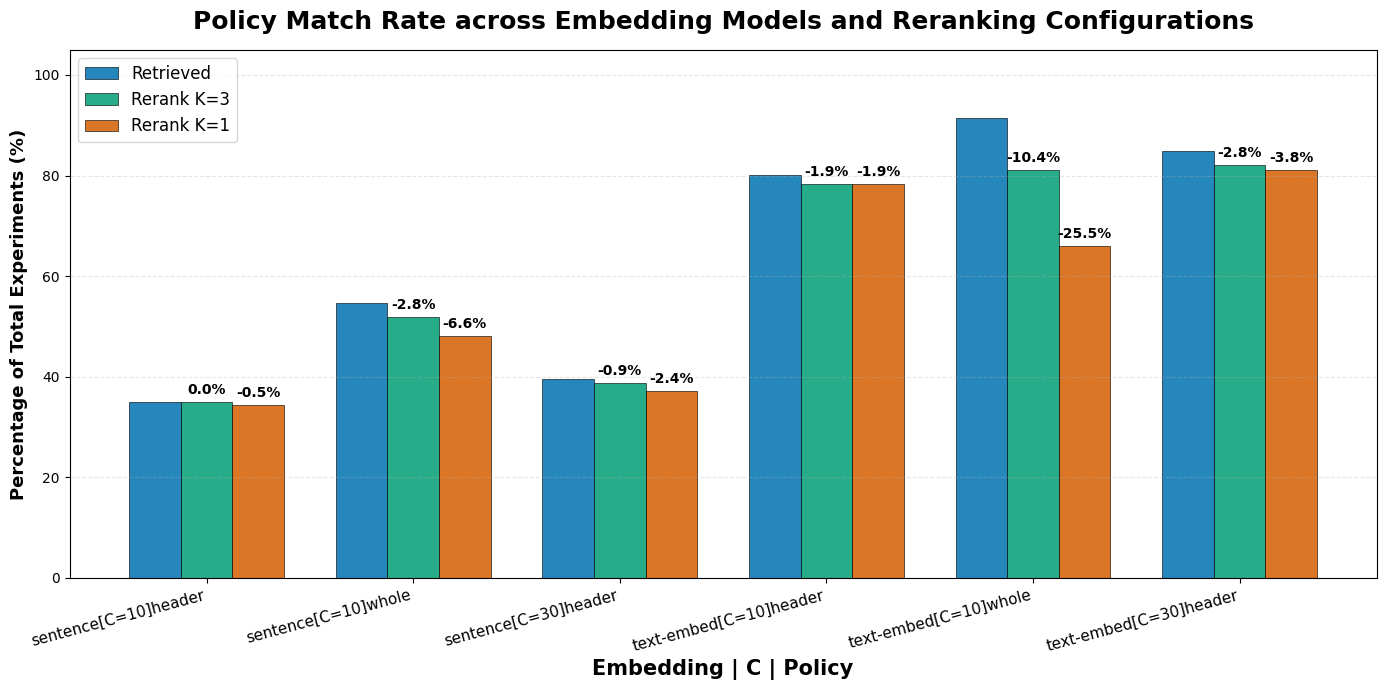

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(grouped))
width = 0.25

colors = ['#0072B2', '#009E73', '#D55E00'] 

retrieved = ax.bar(x - width, grouped['Retrieved_Rate'], width, 
                   label='Retrieved', color=colors[0], alpha=0.85, edgecolor='black', linewidth=0.5)
rerank_k3 = ax.bar(x, grouped['Rerank_K3_Rate'], width, 
                   label='Rerank K=3', color=colors[1], alpha=0.85, edgecolor='black', linewidth=0.5)
rerank_k1 = ax.bar(x + width, grouped['Rerank_K1_Rate'], width, 
                   label='Rerank K=1', color=colors[2], alpha=0.85, edgecolor='black', linewidth=0.5)

def add_value_labels(bars, values, reference_values, show_label=True):
    for bar, val, ref_val in zip(bars, values, reference_values):
        if not np.isnan(val) and show_label:
            height = bar.get_height()
            diff = val - ref_val
            label_text = f'{diff:+.1f}%' if diff != 0 else f'{diff:.1f}%'
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   label_text, ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(retrieved, grouped['Retrieved_Rate'], grouped['Retrieved_Rate'], show_label=False)
add_value_labels(rerank_k3, grouped['Rerank_K3_Rate'], grouped['Retrieved_Rate'])
add_value_labels(rerank_k1, grouped['Rerank_K1_Rate'], grouped['Retrieved_Rate'])

ax.set_ylabel('Percentage of Total Experiments (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Embedding | C | Policy', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(grouped['label'], fontsize=11, rotation=15, ha='right')
ax.set_ylim(0, 105)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.title('Policy Match Rate across Embedding Models and Reranking Configurations', fontsize=18, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('Figure4.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
data = {
    'Model': ['GPT-5-Mini', 'GPT-5-Mini', 'GPT-5', 'GPT-5'],
    'Top_C': [10, 30, 10, 30],
    'Baseline': [61.62, 61.95, 60.27, 59.26],
    'RAG': [72.05, 74.07, 69.36, 68.01],
    'File-Agent': [73.40, 73.40, 69.70, 69.70]
}

df = pd.DataFrame(data)

df['label'] = df['Model'] + ' (C=' + df['Top_C'].astype(str) + ')'

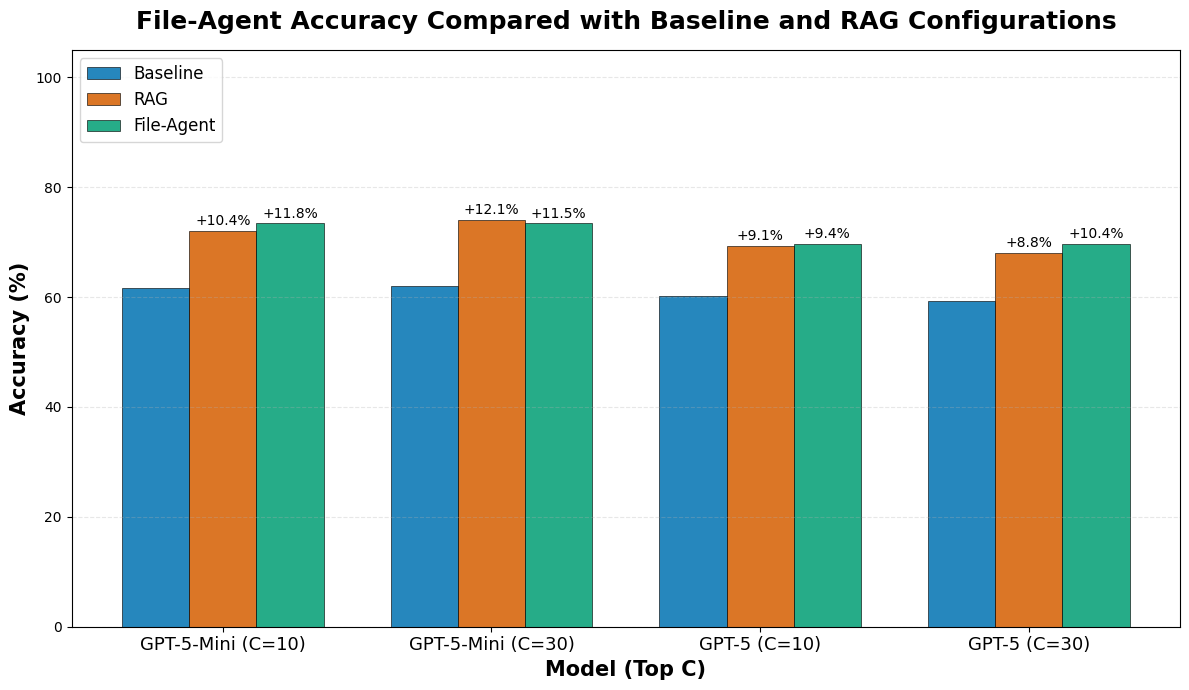

In [3]:
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(df))
width = 0.25

colors = ['#0072B2', '#D55E00', '#009E73']  
baseline = ax.bar(x - width, df['Baseline'], width, 
                  label='Baseline', color=colors[0], alpha=0.85, edgecolor='black', linewidth=0.5)
internal = ax.bar(x, df['RAG'], width, 
                  label='RAG', color=colors[1], alpha=0.85, edgecolor='black', linewidth=0.5)
onedoc = ax.bar(x + width, df['File-Agent'], width, 
                label='File-Agent', color=colors[2], alpha=0.85, edgecolor='black', linewidth=0.5)

def add_value_labels(bars, baseline_values=None, show_diff=False):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if show_diff and baseline_values is not None:
            diff = height - baseline_values[i]
            label_text = f'{diff:+.1f}%'
        else:
            label_text = f'{height:.1f}%'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               label_text, ha='center', va='bottom', fontsize=10)

#add_value_labels(baseline)
add_value_labels(internal, baseline_values=df['Baseline'].values, show_diff=True)
add_value_labels(onedoc, baseline_values=df['Baseline'].values, show_diff=True)

ax.set_ylabel('Accuracy (%)', fontsize=15, fontweight='bold')
ax.set_xlabel('Model (Top C)', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['label'], fontsize=13)
ax.set_ylim(0, 105)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.title('File-Agent Accuracy Compared with Baseline and RAG Configurations', fontsize=18, fontweight='bold', pad=15)
plt.tight_layout()
#plt.savefig('qa_performance_style1.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
df = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_qna_combined_results.csv')

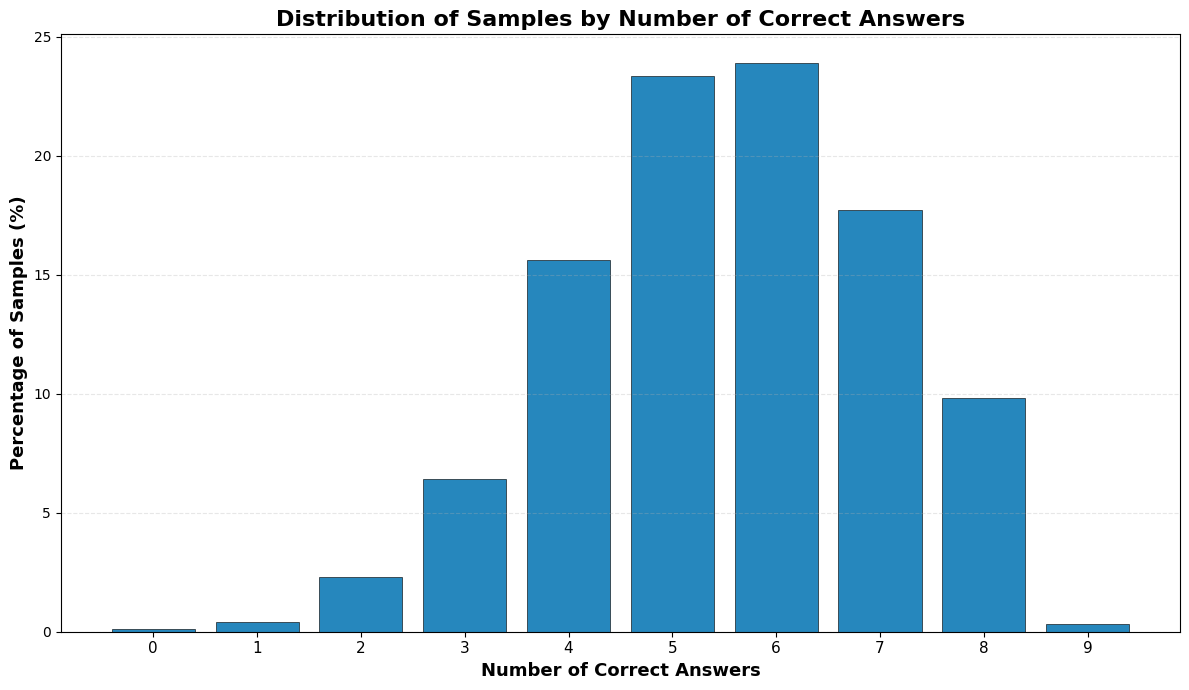

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))

correct_counts = df['correct'].value_counts().sort_index()
percentages = (correct_counts / len(df)) * 100

ax.bar(correct_counts.index, percentages, width=0.8, alpha=0.85, 
       color='#0072B2', edgecolor='black', linewidth=0.5)

ax.set_xlabel('Number of Correct Answers', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage of Samples (%)', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Samples by Number of Correct Answers', fontsize=16, fontweight='bold')
ax.set_xticks(range(10))
ax.set_xticklabels(range(10), fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
#plt.savefig('qna_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

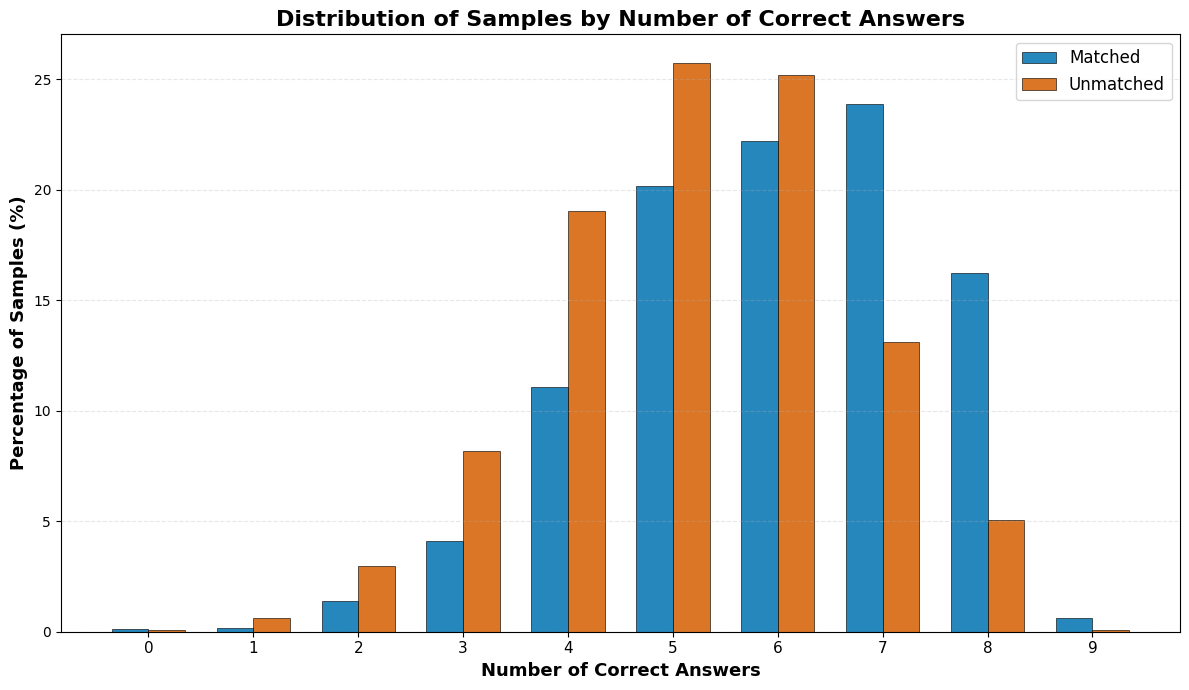

In [11]:
matched_df = df[df['match'] == 1]
unmatched_df = df[df['match'] == 0]

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(10)
width = 0.35

matched_counts = matched_df['correct'].value_counts().reindex(range(10), fill_value=0)
matched_percentages = (matched_counts / len(matched_df)) * 100

unmatched_counts = unmatched_df['correct'].value_counts().reindex(range(10), fill_value=0)
unmatched_percentages = (unmatched_counts / len(unmatched_df)) * 100

colors = ['#0072B2', '#D55E00'] 
ax.bar(x - width/2, matched_percentages, width, alpha=0.85, 
       label='Matched', color=colors[0], edgecolor='black', linewidth=0.5)
ax.bar(x + width/2, unmatched_percentages, width, alpha=0.85, 
       label='Unmatched', color=colors[1], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Number of Correct Answers', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage of Samples (%)', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Samples by Number of Correct Answers', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(range(10), fontsize=11)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
#plt.savefig('qna_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

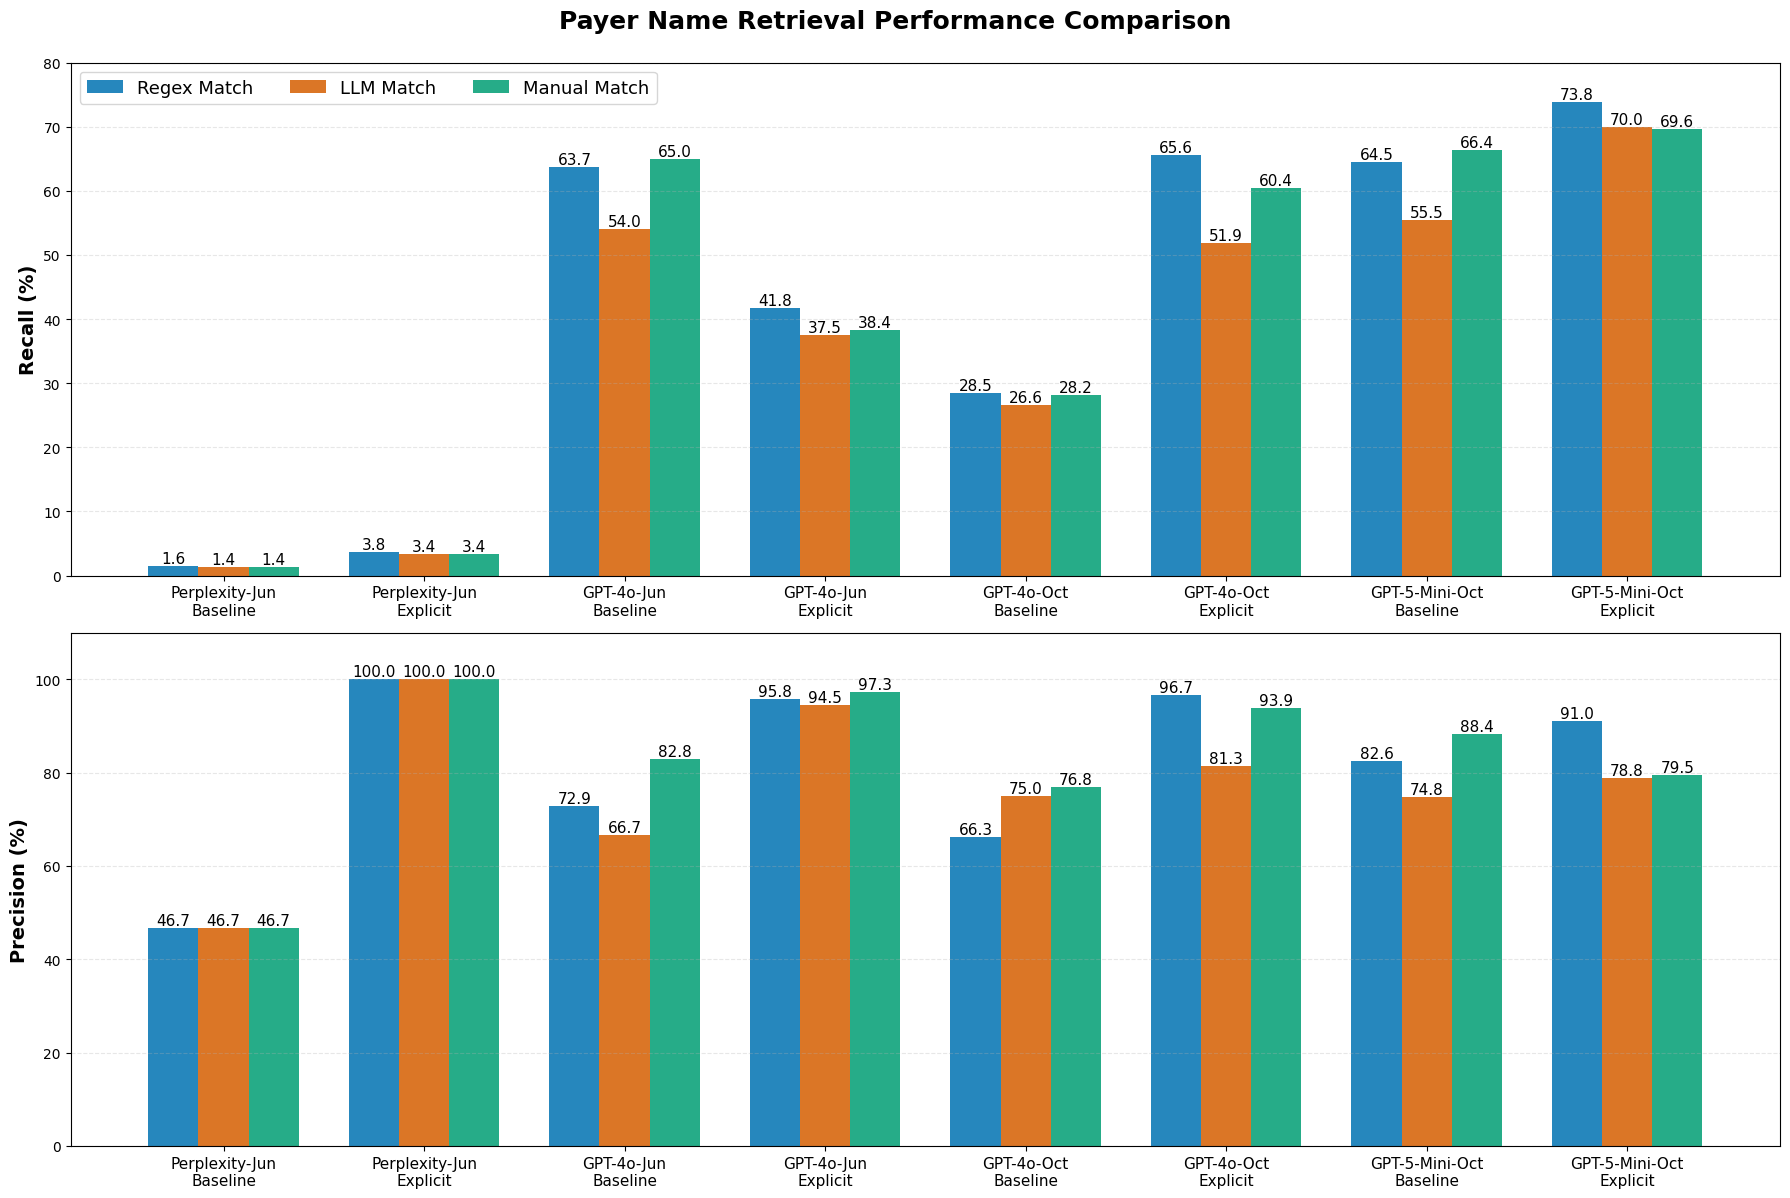

In [7]:
# Figure 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

x = np.arange(len(model_prompts))  # 8개 그룹
width = 0.25  # 3개 bar를 위한 너비

# Color blind friendly (3개만)
colors = ['#0072B2', '#D55E00', '#009E73']
labels = ['Regex Match', 'LLM Match', 'Manual Match']

# Recall 그래프 (위)
recall_data = [recall_regex, recall_llm, recall_manual]
for idx, (data, label, color) in enumerate(zip(recall_data, labels, colors)):
    offset = (idx - 1) * width
    bars = ax1.bar(x + offset, data, width, label=label, color=color, alpha=0.85)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=11, rotation=0)

ax1.set_ylabel('Recall (%)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_prompts, fontsize=11)
ax1.legend(fontsize=13, loc='upper left', ncol=3)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 80)

# Precision 그래프 (아래)
precision_data = [precision_regex, precision_llm, precision_manual]
for idx, (data, label, color) in enumerate(zip(precision_data, labels, colors)):
    offset = (idx - 1) * width
    bars = ax2.bar(x + offset, data, width, label=label, color=color, alpha=0.85)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=11, rotation=0)

ax2.set_ylabel('Precision (%)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_prompts, fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 110)

plt.suptitle('Payer Name Retrieval Performance Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

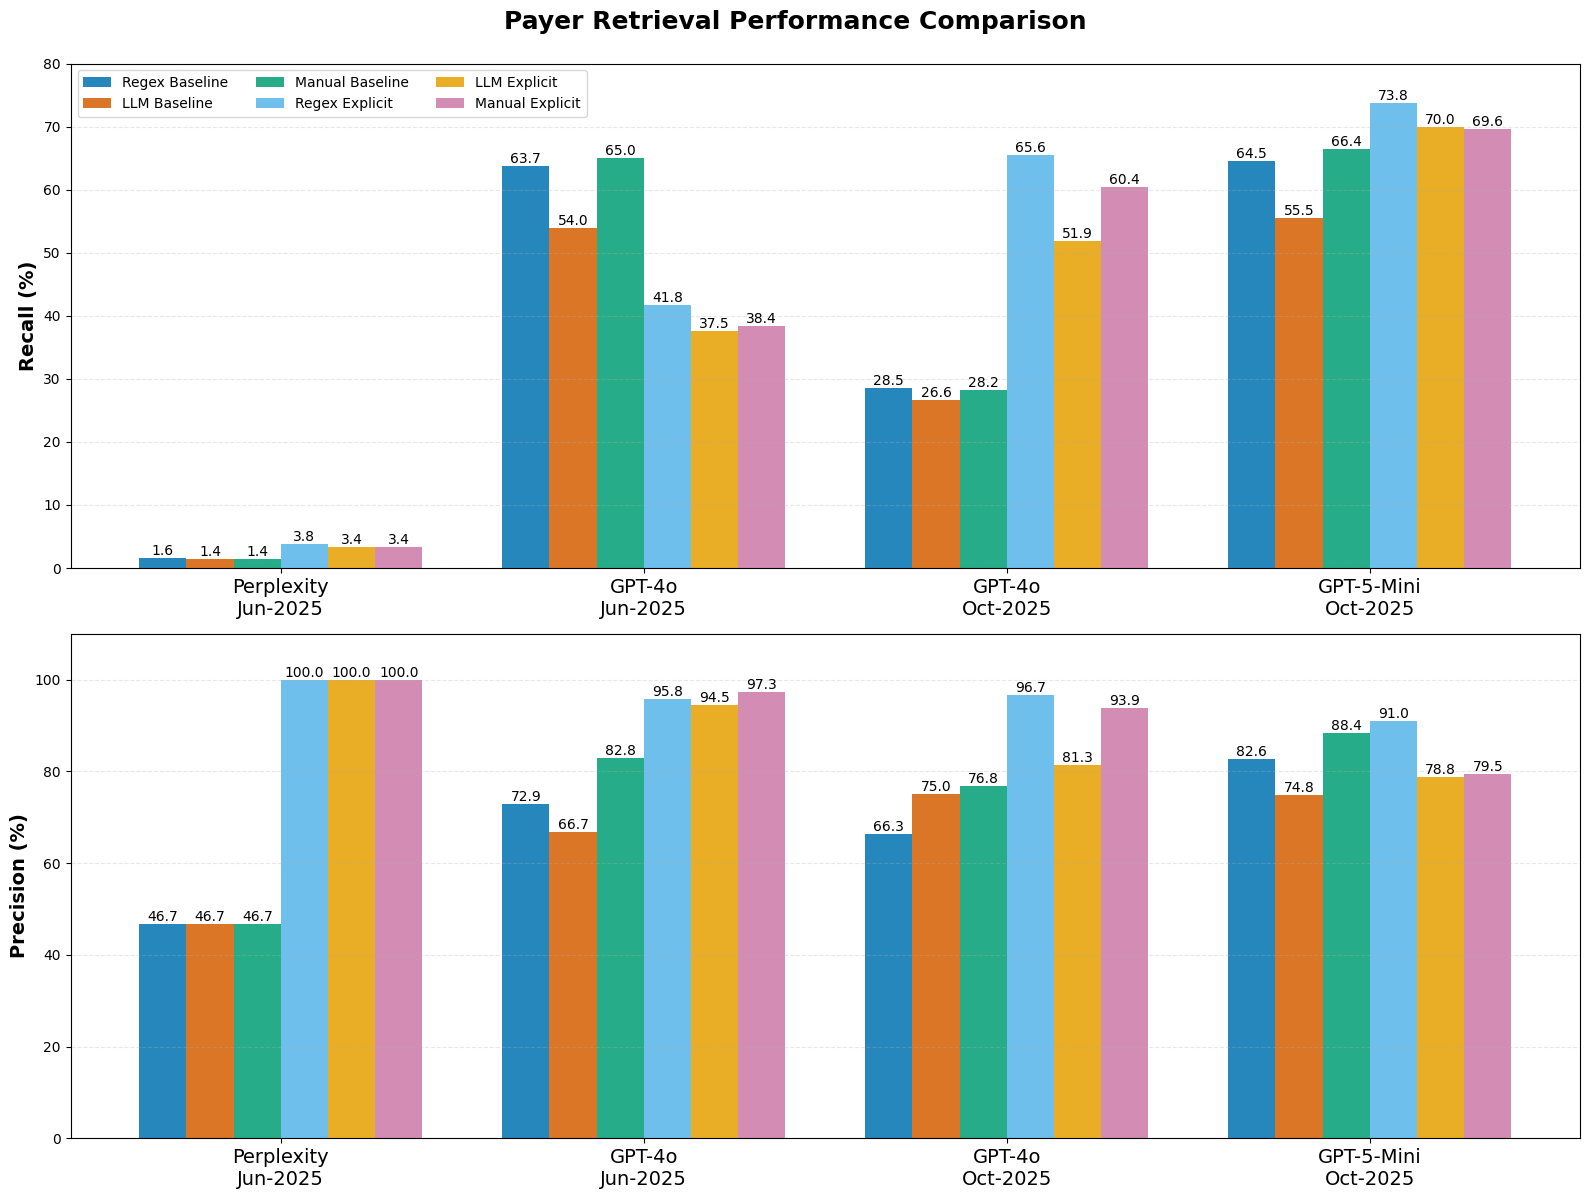

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
x = np.arange(len(models))
width = 0.13

colors = ['#0072B2', '#D55E00', '#009E73', '#56B4E9', '#E69F00', '#CC79A7']
labels = ['Regex Baseline', 'LLM Baseline', 'Manual Baseline', 
          'Regex Explicit', 'LLM Explicit', 'Manual Explicit']

for idx, (key, label, color) in enumerate(zip(data_recall.keys(), labels, colors)):
    offset = (idx - 2.5) * width
    bars = ax1.bar(x + offset, data_recall[key], width, label=label, color=color, alpha=0.85)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, rotation=0)

ax1.set_ylabel('Recall (%)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=14)
ax1.legend(fontsize=10, loc='upper left', ncol=3)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 80)

# Precision 그래프 (아래) - legend 제거
for idx, (key, label, color) in enumerate(zip(data.keys(), labels, colors)):
    offset = (idx - 2.5) * width
    bars = ax2.bar(x + offset, data[key], width, label=label, color=color, alpha=0.85)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, rotation=0)

ax2.set_ylabel('Precision (%)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, fontsize=14)
# ax2.legend() 제거됨
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 110)

plt.suptitle('Payer Retrieval Performance Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/genedx_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
baseline = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/eval/all_baseline_matched_question_accuracy.csv')
rag = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/eval/overall_question_accuracy_rag.csv')
one_doc = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/eval/overall_question_accuracy_withgpt4o.csv')
baseline_unmatched = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/eval/overall_question_accuracy_baseline_unmatched.csv')
rag_unmatched = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/eval/all_sentence_unmatched_question_accuracy.csv')

question_labels = [
    'Q0: Test',
    'Q1: Age',
    'Q2: Provider',
    'Q3: Medical-Necessity',
    'Q4: Pre-Tests',
    'Q5: Family-History',
    'Q6: Genetic-Counseling',
    'Q7: CPT-Code',
    'Q8: Decision'
]

# Matched 데이터 추출 (accuracy 컬럼 사용)
baseline_matched = baseline['accuracy'].tolist()
rag_matched = rag['accuracy'].tolist()
file_agent_matched = one_doc['accuracy'].tolist()

# Unmatched 데이터 추출
baseline_unmatched_data = baseline_unmatched['accuracy'].tolist()
rag_unmatched_data = rag_unmatched['accuracy'].tolist()

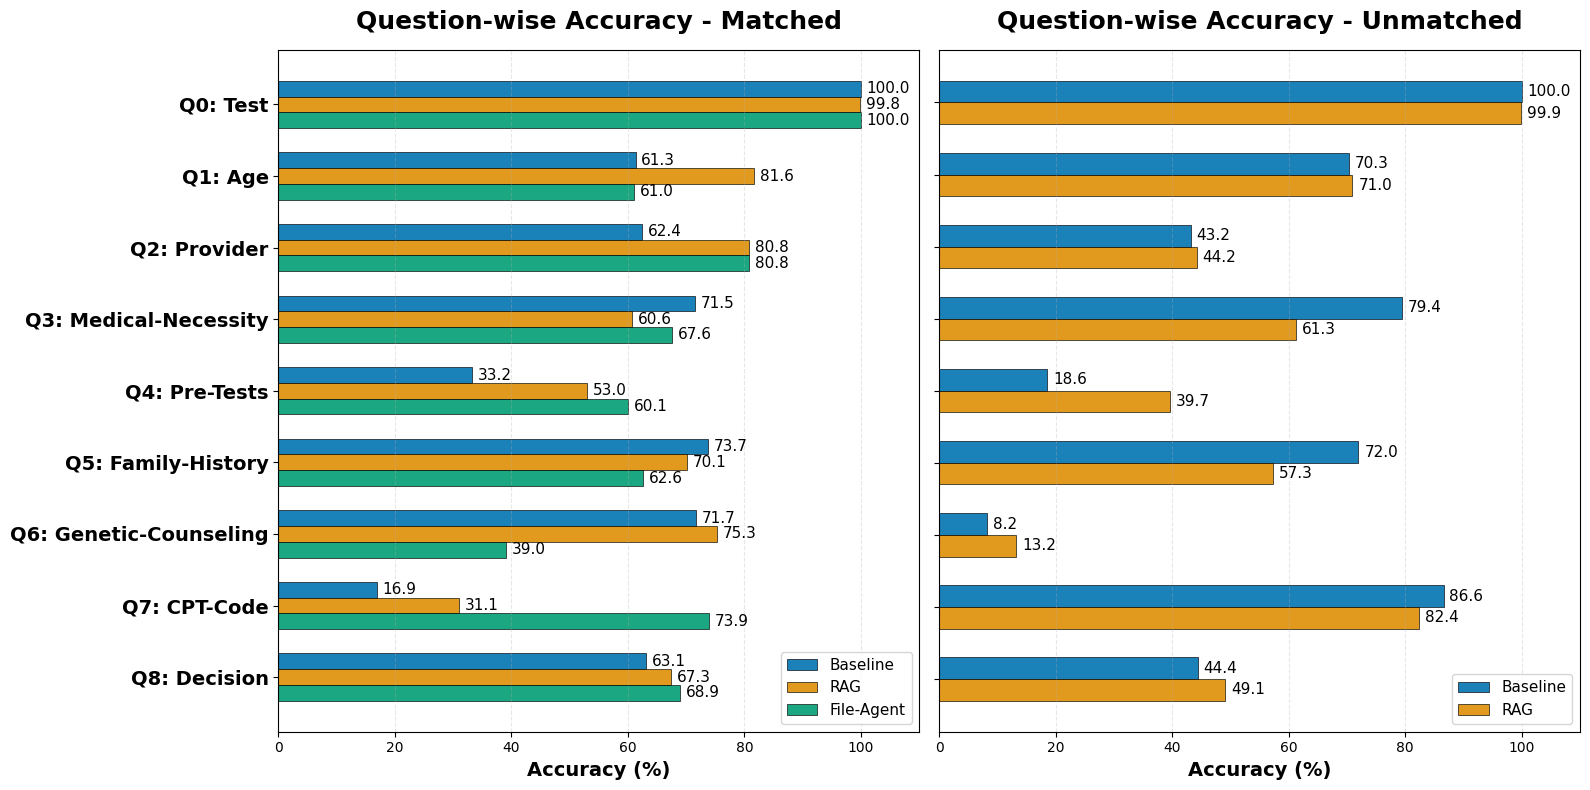

In [6]:
# Figure 생성 (horizontal로 변경)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 왼쪽: Matched
y = np.arange(len(question_labels))
height = 0.22

bars1 = ax1.barh(y - height, baseline_matched, height, label='Baseline', 
                 color='#0173B2', alpha=0.9, edgecolor='black', linewidth=0.5)
bars2 = ax1.barh(y, rag_matched, height, label='RAG', 
                 color='#DE8F05', alpha=0.9, edgecolor='black', linewidth=0.5)
bars3 = ax1.barh(y + height, file_agent_matched, height, label='File-Agent', 
                 color='#029E73', alpha=0.9, edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

#ax1.set_ylabel('Question', fontsize=14, fontweight='bold')
ax1.set_xlabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Question-wise Accuracy - Matched', fontsize=18, fontweight='bold', pad=15)
ax1.set_yticks(y)
ax1.set_yticklabels(question_labels, fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, 110)
ax1.invert_yaxis()  # Q0이 위로 오도록

# 오른쪽: Unmatched
height_unmatched = 0.3

bars4 = ax2.barh(y - height_unmatched/2, baseline_unmatched_data, height_unmatched, 
                 label='Baseline', color='#0173B2', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)
bars5 = ax2.barh(y + height_unmatched/2, rag_unmatched_data, height_unmatched, 
                 label='RAG', color='#DE8F05', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars4, bars5]:
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

#ax2.set_ylabel('Question', fontsize=14, fontweight='bold')
ax2.set_xlabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax2.set_title('Question-wise Accuracy - Unmatched', fontsize=18, fontweight='bold', pad=15)
ax2.set_yticks(y)
ax2.set_yticklabels([])
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_xlim(0, 110)
ax2.invert_yaxis()  # Q0이 위로 오도록

plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/question_accuracy_horizontal.png', dpi=300, bbox_inches='tight')
plt.show()

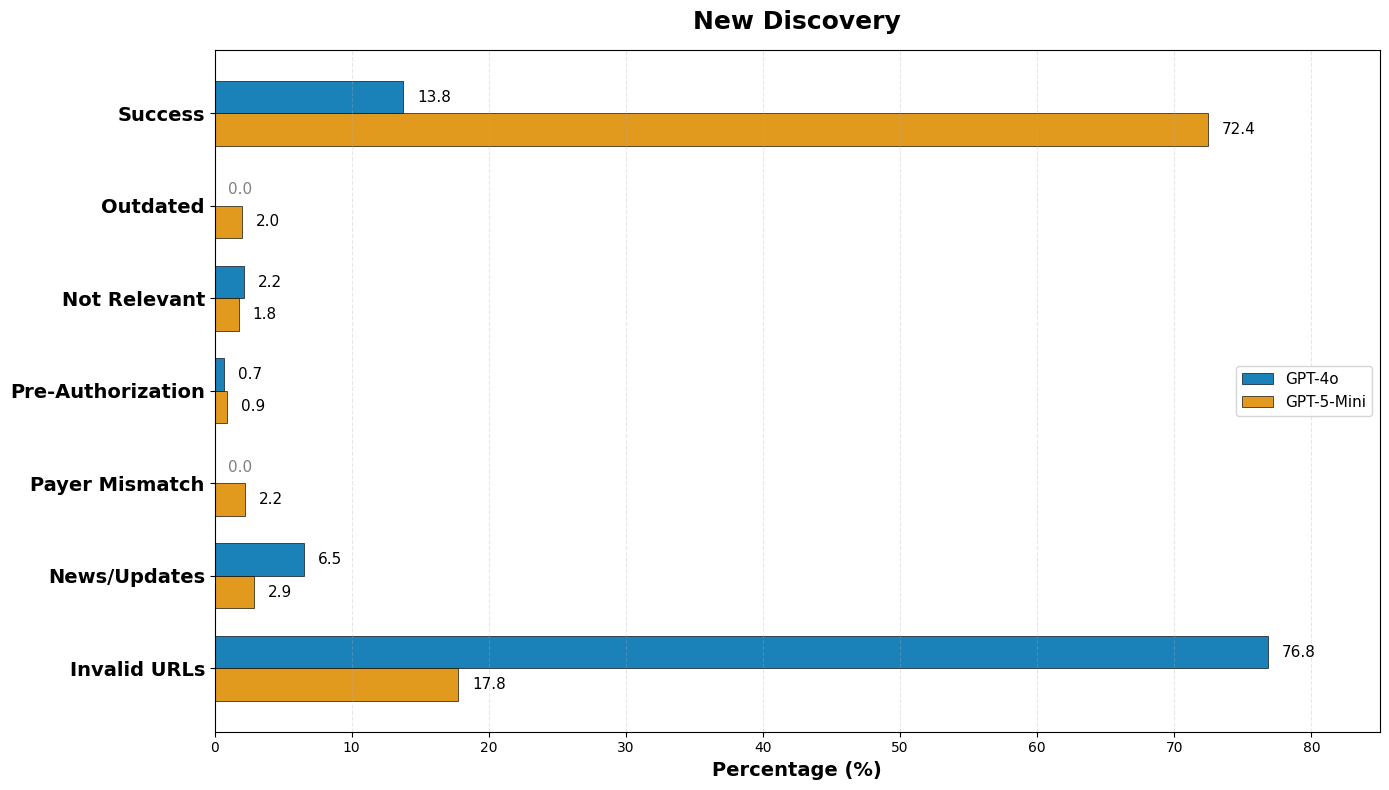

In [ ]:
# 카테고리 레이블 (짧게)
category_labels = [
    'Success',
    'Outdated',
    'Not Relevant',
    'Pre-Authorization',
    'Payer Mismatch',
    'News/Updates',
    'Invalid URLs'
]

# 데이터 (퍼센트) - Jun 관련 제거
gpt4o = [13.77, 0.00, 2.17, 0.72, 0.00, 6.52, 76.81]
gpt5_mini = [72.44, 2.00, 1.78, 0.89, 2.22, 2.89, 17.78]

# Total numbers (참고용)
totals = {
    'GPT-4o': 138,
    'GPT-5-Mini': 450
}

# Figure 생성
fig, ax = plt.subplots(figsize=(14, 8))
y = np.arange(len(category_labels))
height = 0.35

# Color blind friendly palette (2개만)
colors = ['#0173B2', '#DE8F05']
models = ['GPT-4o', 'GPT-5-Mini']
data = [gpt4o, gpt5_mini]

# 2개의 horizontal bar 그리기
for idx, (model_data, color, model_name) in enumerate(zip(data, colors, models)):
    offset = (idx - 0.5) * height
    bars = ax.barh(y + offset, model_data, height, label=model_name, 
                   color=color, alpha=0.9, edgecolor='black', linewidth=0.5)
    
    # 값 표시 (0이 아닌 경우만)
    for bar, value in zip(bars, model_data):
        if value > 0:
            width = bar.get_width()
            ax.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{value:.1f}', ha='left', va='center', fontsize=11)
        else:
            # 0인 경우 바 시작 부분에 표시
            ax.text(1, bar.get_y() + bar.get_height()/2.,
                f'{value:.1f}', ha='left', va='center', fontsize=11, color='gray')

ax.set_xlabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_title('New Discovery', fontsize=18, fontweight='bold', pad=15)
ax.set_yticks(y)
ax.set_yticklabels(category_labels, fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='center right')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(0, 85)
ax.invert_yaxis()  # Success가 위로 오도록

plt.tight_layout()
plt.savefig('Figure3.pdf', dpi=300, bbox_inches='tight')
plt.show()

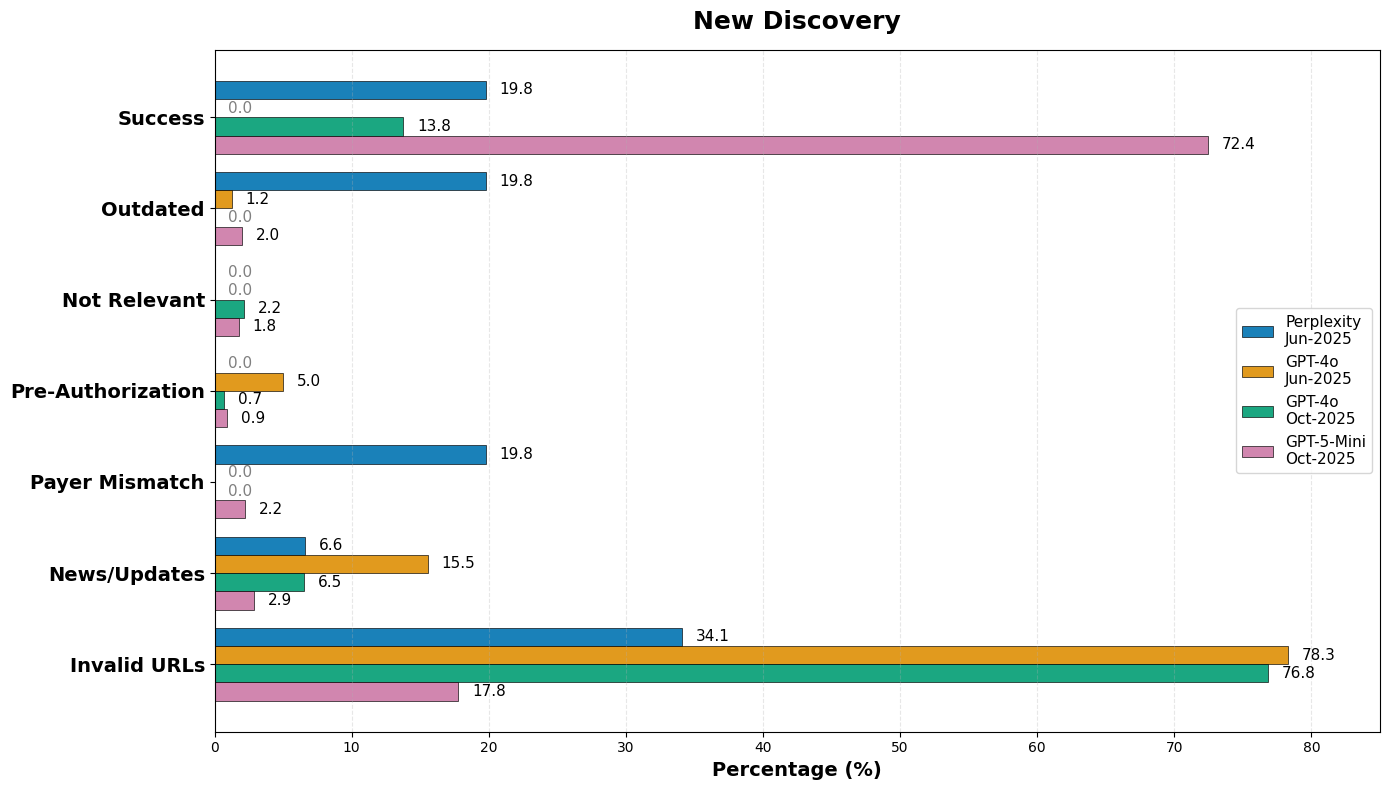

In [26]:
# 카테고리 레이블 (짧게)
category_labels = [
    'Success',
    'Outdated',
    'Not Relevant',
    'Pre-Authorization',
    'Payer Mismatch',
    'News/Updates',
    'Invalid URLs'
]

# 데이터 (퍼센트)
perplexity = [19.78, 19.78, 0.00, 0.00, 19.78, 6.59, 34.07]
gpt4o_jun = [0.00, 1.24, 0.00, 4.97, 0.00, 15.53, 78.26]
gpt4o_oct = [13.77, 0.00, 2.17, 0.72, 0.00, 6.52, 76.81]
gpt5_mini = [72.44, 2.00, 1.78, 0.89, 2.22, 2.89, 17.78]

# Total numbers (참고용, 그래프에 표시 가능)
totals = {
    'Perplexity-Jun-2025': 91,
    'GPT-4o-Jun-2025': 161,
    'GPT-4o-Oct-2025': 138,
    'GPT-5-Mini-Oct-2025': 450
}

# Figure 생성
fig, ax = plt.subplots(figsize=(14, 8))

y = np.arange(len(category_labels))
height = 0.2

# Color blind friendly palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC79A7']
models = ['Perplexity\nJun-2025', 'GPT-4o\nJun-2025', 'GPT-4o\nOct-2025', 'GPT-5-Mini\nOct-2025']
data = [perplexity, gpt4o_jun, gpt4o_oct, gpt5_mini]

# 4개의 horizontal bar 그리기
for idx, (model_data, color, model_name) in enumerate(zip(data, colors, models)):
    offset = (idx - 1.5) * height
    bars = ax.barh(y + offset, model_data, height, label=model_name, 
                   color=color, alpha=0.9, edgecolor='black', linewidth=0.5)
    
    # 값 표시 (0이 아닌 경우만)
    for bar, value in zip(bars, model_data):
        if value > 0:
            width = bar.get_width()
            ax.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{value:.1f}', ha='left', va='center', fontsize=11)
        else:
        # 0인 경우 바 시작 부분에 표시
            ax.text(1, bar.get_y() + bar.get_height()/2.,
                f'{value:.1f}', ha='left', va='center', fontsize=11, color='gray')

# ax.set_ylabel('Category', fontsize=14, fontweight='bold')  # 제거
ax.set_xlabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_title('New Discovery', fontsize=18, fontweight='bold', pad=15)
ax.set_yticks(y)
ax.set_yticklabels(category_labels, fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='center right')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(0, 85)
ax.invert_yaxis()  # Success가 위로 오도록

plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/model_performance_categories.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# 데이터 정의
configs = ['K=1, C=10', 'K=1, C=30', 'K=3, C=10', 'K=3, C=30']

# SentenceTransformer - Baseline
st_baseline_matched = [61.73, 61.94, 63.36, 62.06]
st_baseline_unmatched = [60.63, 57.41, 58.94, 59.15]
st_baseline_overall = [
    (61.73*36 + 60.63*70) / 106,
    (61.94*40 + 57.41*66) / 106,
    (63.36*37 + 58.94*69) / 106,
    (62.06*41 + 59.15*65) / 106
]

# SentenceTransformer - Internal-QA
st_matched = [71.60, 73.33, 66.07, 64.50]
st_unmatched = [55.71, 52.02, 57.81, 62.39]
st_overall = [
    (71.60*36 + 55.71*70) / 106,
    (73.33*40 + 52.02*66) / 106,
    (66.07*37 + 57.81*69) / 106,
    (64.50*41 + 62.39*65) / 106
]

# Text-Embedding - Baseline
te_baseline_matched = [62.25, 59.43, 61.85, 62.07]
te_baseline_unmatched = [56.52, 57.78, 55.56, 52.05]
te_baseline_overall = [
    (62.25*83 + 56.52*23) / 106,
    (59.43*86 + 57.78*20) / 106,
    (61.85*83 + 55.56*23) / 106,
    (62.07*87 + 52.05*19) / 106
]

# Text-Embedding - Internal-QA
te_matched = [67.87, 68.60, 68.54, 71.01]
te_unmatched = [44.44, 56.67, 56.04, 63.16]
te_overall = [
    (67.87*83 + 44.44*23) / 106,
    (68.60*86 + 56.67*20) / 106,
    (68.54*83 + 56.04*23) / 106,
    (71.01*87 + 63.16*19) / 106
]

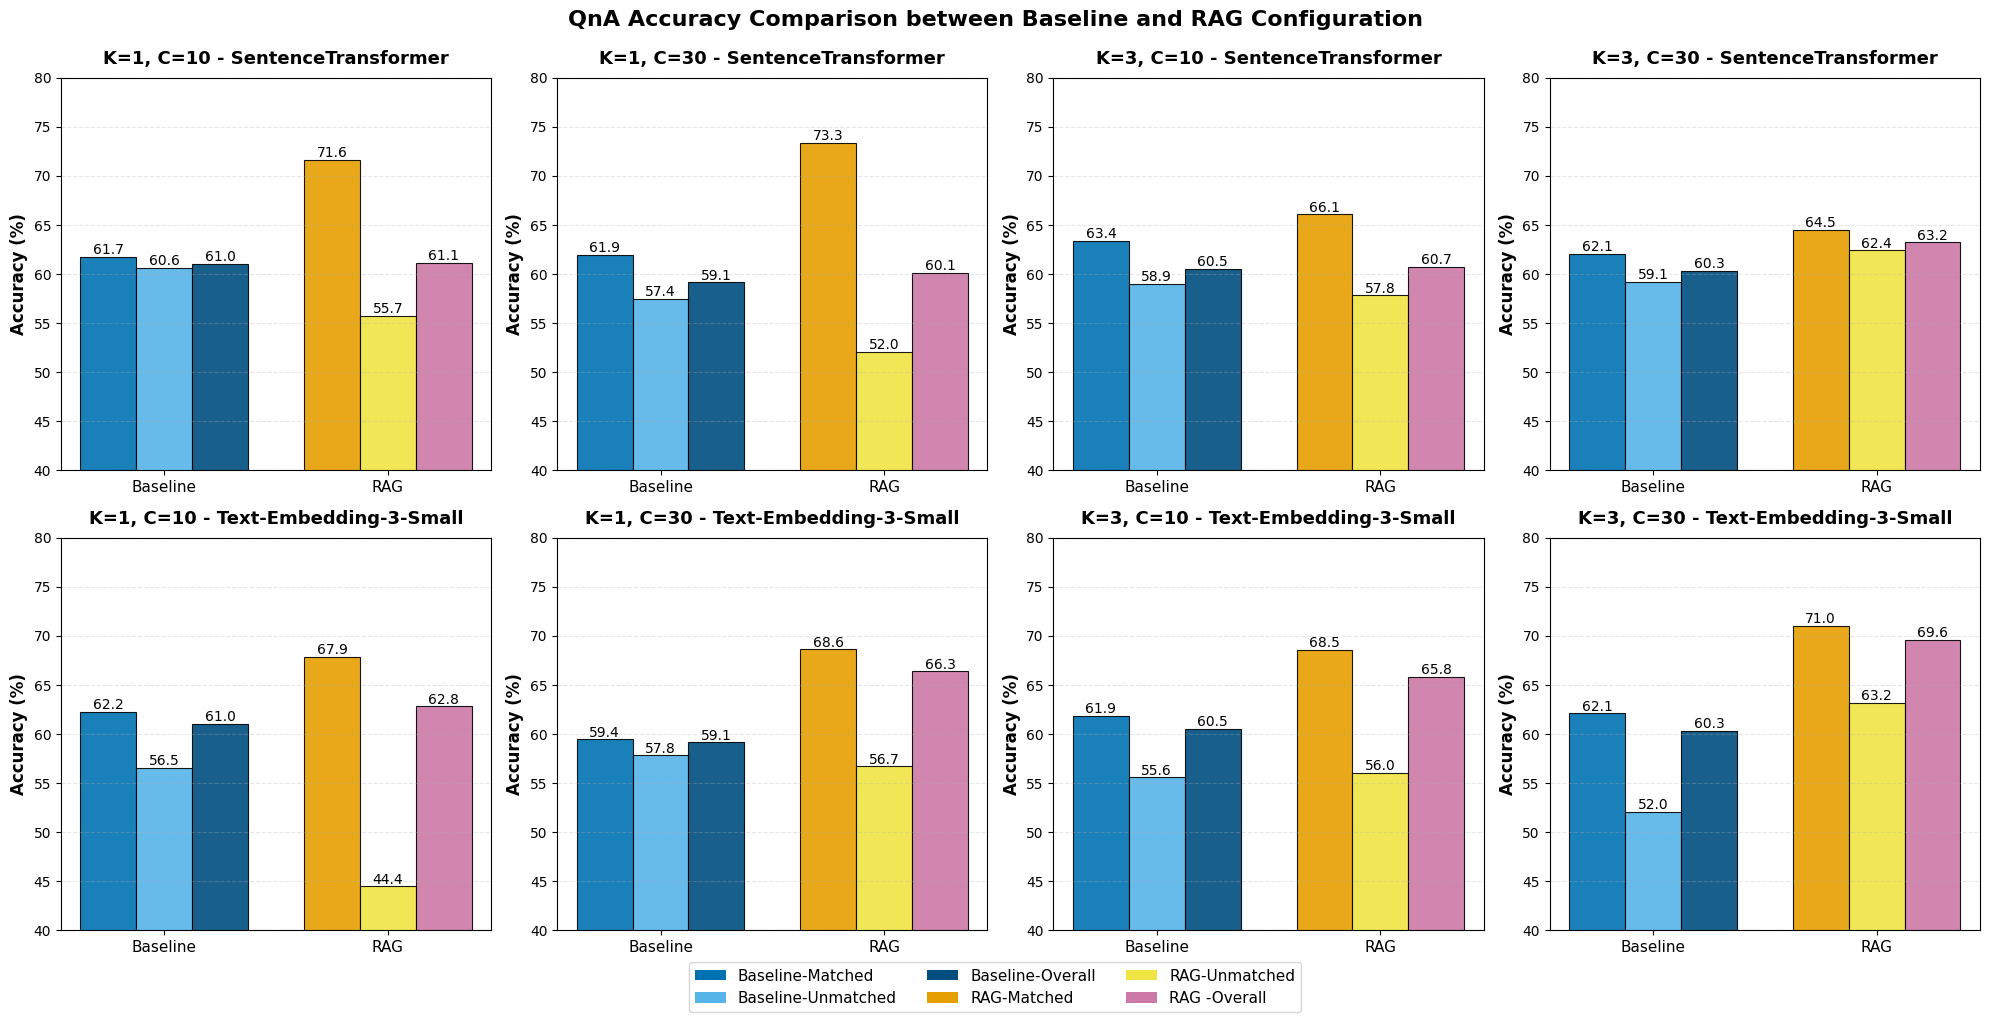

그래프가 저장되었습니다!


In [ ]:
# Figure 생성 (4개 subplot - 각 configuration별)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Color blind friendly colors
colors_baseline = ['#0072B2', '#56B4E9', '#004D80']  # 파란색 계열
colors_internal = ['#E69F00', '#F0E442', '#CC79A7']  # 주황/노랑/보라 계열

for idx in range(8):
    ax = axes[idx]
    config_idx = idx % 4
    config = configs[config_idx]

    x = np.arange(2)
    width = 0.25
    
    if idx < 4:    # SentenceTransformer
        baseline_data = [st_baseline_matched[config_idx], st_baseline_unmatched[config_idx], st_baseline_overall[config_idx]]
        internal_data = [st_matched[config_idx], st_unmatched[config_idx], st_overall[config_idx]]
        title = f'{config} - SentenceTransformer'
    else:  # Text-Embedding-3-Small
        baseline_data = [te_baseline_matched[config_idx], te_baseline_unmatched[config_idx], te_baseline_overall[config_idx]]
        internal_data = [te_matched[config_idx], te_unmatched[config_idx], te_overall[config_idx]]
        title = f'{config} - Text-Embedding-3-Small'
    
    # Baseline bars (파란색 계열)
    for i, (value, color) in enumerate(zip(baseline_data, colors_baseline)):
        offset = (i - 1) * width
        bar = ax.bar(0 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(0 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Internal-QA bars (주황색 계열)
    for i, (value, color) in enumerate(zip(internal_data, colors_internal)):
        offset = (i - 1) * width
        bar = ax.bar(1 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(1 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(['Baseline', 'RAG'], fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(40, 80)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#0072B2', label='Baseline-Matched'),
    Patch(facecolor='#56B4E9', label='Baseline-Unmatched'),
    Patch(facecolor='#004D80', label='Baseline-Overall'),
    Patch(facecolor='#E69F00', label='RAG-Matched'),
    Patch(facecolor='#F0E442', label='RAG-Unmatched'),
    Patch(facecolor='#CC79A7', label='RAG -Overall')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('QnA Accuracy Comparison between Baseline and RAG Configuration', 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 1])
#plt.savefig('/mnt/user-data/outputs/header_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
